In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/Shared drives/Fall2020DSGirlPower/SI650/project/DATA/TO_data/'

/content/drive/Shared drives/Fall2020DSGirlPower/SI650/project/DATA/TO_data


## Collaborative Filtering Functions

In [4]:
!pip install pyspark

In [5]:
from math import sqrt
import numpy as np
import pandas as pd
# PySpark import
from pyspark.mllib.recommendation import ALS, Rating

## Import Data

In [6]:
data = pd.read_csv('user_res_rating.csv')
# data = data.head(20)
# val_num = data.shape[0]*0.000025
# # train_num = data.shape[0]*0.9
# # val_df = data[-int(val_num):]
# # train_df = data[:int(train_num)]
# # val_df.to_csv('val_data.csv',index = False)
# # train_df.to_csv('train_data.csv',index = False)

In [7]:
business_id_list = ['qoDrPDPEGRsF8I_VgYftjQ	', 
                    'DEdB-wkPV1QzcSFMTTYl-w	', 
                    '9pBcKw24z9nZiHW7Vx_z8A', 
                    'TMUPcmHwUtK3UV-9Rfs_ew	',
                    'OaO_5YeBF9xBXmcgG1t0WA	',
                    'S-BgFH8oqD5n4OsDNhxr9g',
                    'Koofpyww8Y-H9O7vw8mapQ',
                    '95A_eit7YDcEtM7zPO9yHQ',
                    'fuk8V-SmFO0xRyC9eMDarw',
                    'n-ps87_nlV56dKLD7Wep3w	']
user_id = 'OKX-V5j_qfuOebeHeWGrHg'

In [8]:
user = [user_id]
user = np.repeat(user,10).tolist()
rating = np.repeat([5],10).tolist()

In [9]:
test_list = []
for i in business_id_list:
    pair = [user_id,i]
    test_list.append(pair)

In [10]:
d = {'user_id':user,'business_id':business_id_list,'rating':rating}
val_df = pd.DataFrame(data = d)

In [11]:
test_list

[['OKX-V5j_qfuOebeHeWGrHg', 'qoDrPDPEGRsF8I_VgYftjQ\t'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'DEdB-wkPV1QzcSFMTTYl-w\t'],
 ['OKX-V5j_qfuOebeHeWGrHg', '9pBcKw24z9nZiHW7Vx_z8A'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'TMUPcmHwUtK3UV-9Rfs_ew\t'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'OaO_5YeBF9xBXmcgG1t0WA\t'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'S-BgFH8oqD5n4OsDNhxr9g'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'Koofpyww8Y-H9O7vw8mapQ'],
 ['OKX-V5j_qfuOebeHeWGrHg', '95A_eit7YDcEtM7zPO9yHQ'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'fuk8V-SmFO0xRyC9eMDarw'],
 ['OKX-V5j_qfuOebeHeWGrHg', 'n-ps87_nlV56dKLD7Wep3w\t']]

In [12]:
for pair in test_list:
    index = data[(data['user_id']== pair[0]) & (data['business_id']== pair[1])].index
    data.drop(index, inplace = True)
train_df = data
val_df.to_csv('val_data.csv',index = False)
train_df.to_csv('train_data.csv',index = False)

### Build User Business Matrix

In [13]:
def build_rating_table(data):
    """ Build rating look-up table for user and business pair """
    table = {}
    for user, business, rating in data.toLocalIterator():
        table[(user, business)] = rating
    
    return table


def build_user_sets(data):
    """ Aggregate all businesses to users who have rated them """
    user_rdd = data.map(lambda x: (x[0], x[1])).groupByKey()
    user_sets = {}
    for key, vals in user_rdd.toLocalIterator():
        user_sets[key] = set(vals)
    
    return user_sets


def build_business_sets(data):
    """ Aggregate all users to businesses who have been rated by them """
    business_rdd = data.map(lambda x: (x[1], x[0])).groupByKey()
    business_sets = {}
    for key, vals in business_rdd.toLocalIterator():
        business_sets[key] = set(vals)
    
    return business_sets

### Deal with cold start

In [14]:
def find_median(attri_sets, ratings, case):
    """ Find the median rating from the set """
    ave = []
    if case == 'user':
        for user, businesses in attri_sets.items():
            ave.append(sum(ratings[(user, b)] for b in businesses) / len(businesses))
    elif case == 'business':
        for business, users in attri_sets.items():
            ave.append(sum(ratings[(u, business)] for u in users) / len(users))
    ave.sort()
    return ave[len(ave) // 2]

### Collaborative Filtering

In [15]:
def predict_rating(train_data, test_data, case_num):
    """ Predict user, business rating """
    rating_table = build_rating_table(train_data)
    user_sets = build_user_sets(train_data)
    median_user_rating = find_median(user_sets, rating_table, 'user')
    if case_num == 1:
        return predict_rating_model_based(train_data, test_data, median_user_rating)

    weights = {}
    averages = {}
    business_sets = build_business_sets(train_data)
    median_business_rating = find_median(business_sets, rating_table, 'business')

    if case_num == 2:
        return test_data.map(lambda x: predict_rating_user_based(x[0], x[1],
                             rating_table, user_sets, business_sets, weights,
                             averages, median_user_rating, median_business_rating,
                             case_num))

    return test_data.map(lambda x: predict_rating_item_based(x[0], x[1],
                         rating_table, user_sets, business_sets, weights, averages,
                         median_user_rating, median_business_rating, case_num))

#### 1. ALS algorithm

In [16]:
def predict_rating_model_based(train_data, test_data, median_rating):
    """ Predict rating for user, business pair using model-based CF """
    user_mapping, business_mapping = _create_mapping(train_data, test_data)

    train_data = train_data.map(lambda x: Rating(user_mapping[x[0]], business_mapping[x[1]], x[2]))
    test_data = test_data.map(lambda x: ((x[0], x[1]), 1))
    mapped_test_data = test_data.map(lambda x: (user_mapping[x[0][0]], business_mapping[x[0][1]]))

    # create model
    model = ALS.train(train_data, 5, 10)
    predictions = model.predictAll(mapped_test_data)\
                  .map(lambda x: ((user_mapping[x[0]], business_mapping[x[1]]), x[2]))

    # collect all the cold start
    cold_starts = test_data.subtractByKey(predictions).map(lambda x: (x[0], median_rating))

    return predictions.union(cold_starts)\
           .map(lambda x: (x[0][0], x[0][1], _round_rating_model_based(x[1])))

#### 2. User_based CF

In [17]:
def predict_rating_user_based(user, business, ratings, user_sets, business_sets,
                              user_weights, user_averages, median_user_rating,
                              median_business_rating, case_num):
    """ Predict rating for user, business pair using user-based CF """
    if (user, business) in ratings:
        return (user, business, ratings[(user, business)])

    # cold start for new business
    if business not in business_sets:
        return (user, business, median_business_rating)

    # cold start for new user
    if user not in user_sets:
        return (user, business, median_user_rating)

    weights = _get_neighbor_weights(user, business_sets[business], ratings,
                                   user_sets, user_weights, case_num)

    ave_rating = _get_ave_rating(user, ratings, user_sets, user_averages)
    weighted_rating = _get_weighted_rating(business, weights, ratings, user_sets, user_averages)
    return (user, business, _round_rating_user_based(ave_rating + weighted_rating))

#### 3. Item-based CF

In [18]:
def predict_rating_item_based(user, business, ratings, user_sets, business_sets,
                              business_weights, business_averages, median_user_rating,
                              median_business_rating, case_num):
    """ Predict rating for user, business pair using item-based CF """
    if (user, business) in ratings:
        return (user, business, ratings[(user, business)])

    # cold start for new business
    if business not in business_sets:
        return (user, business, median_business_rating)

    # cold start for new user
    if user not in user_sets:
        return (user, business, median_user_rating)

    weights = _get_neighbor_weights(business, user_sets[user], ratings,
                                   business_sets, business_weights, case_num)

    total_weights = weighted_rating = 0.0
    if weights:
        for neighbor, weight in weights:
            total_weights += abs(weight)
            weighted_rating += ratings[(user, neighbor)] * weight
        weighted_rating = weighted_rating / total_weights
    else:
        if business not in business_averages:
            all_users = business_sets[business]
            average_rating = sum(ratings[(u, business)] for u in all_users) / len(all_users)
            business_averages[business] = average_rating
        weighted_rating = business_averages[business]

    return (user, business, _round_rating_item_based(weighted_rating))

### Supportive functions

In [19]:
def _create_mapping(train_data, test_data):
    """ Create two-way mapping between ID and indices """
    user_mapping = {}
    business_mapping = {}
    user_counter = business_counter = 0
    for user, business, _ in train_data.toLocalIterator():
        if user not in user_mapping:
            user_mapping[user] = user_counter
            user_mapping[user_counter] = user
            user_counter += 1
        if business not in business_mapping:
            business_mapping[business] = business_counter
            business_mapping[business_counter] = business
            business_counter += 1

    for user, business, _ in test_data.toLocalIterator():
        if user not in user_mapping:
            user_mapping[user] = user_counter
            user_mapping[user_counter] = user
            user_counter += 1
        if business not in business_mapping:
            business_mapping[business] = business_counter
            business_mapping[business_counter] = business
            business_counter += 1
    
    return user_mapping, business_mapping

In [20]:
def _get_neighbor_weights(target, neighbors, ratings, attri_sets, prev_weights,
                         case_num):
    """ Calculate weight between target and neighbor """
    all_weights = []
    for neighbor in neighbors:
        pair = (target, neighbor)
        weight = 0.0
        if pair in prev_weights:
            weight = prev_weights[pair]
        else:
            weight = _get_weight(target, neighbor, ratings, attri_sets, case_num)
            prev_weights[pair] = weight

    return all_weights


def _get_weight(target, neighbor, ratings, attri_sets, case_num):
    """ Calculate weight for both users """
    co_rated = attri_sets[target].intersection(attri_sets[neighbor])
    vec_1 = []
    vec_2 = []
    if case_num == 2:
        vec_1 = [ratings[(target, attri)] for attri in co_rated]
        vec_2 = [ratings[(neighbor, attri)] for attri in co_rated]
    elif case_num == 3:
        vec_1 = [ratings[(attri, target)] for attri in co_rated]
        vec_2 = [ratings[(attri, neighbor)] for attri in co_rated]
    else:
        raise ValueError("Wrong case number")

    weight = 0.0
    num = len(co_rated)
    if num > 1:
        # find average
        ave_1 = sum(vec_1) / num
        ave_2 = sum(vec_2) / num

        # normalize vector
        vec_1 = [n - ave_1 for n in vec_1]
        vec_2 = [n - ave_2 for n in vec_2]
        numerator = sum(vec_1[i] * vec_2[i] for i in range(num))

        # numerator is 0
        if not numerator:
            return 0.0

        # calculate magnitude of both vectors
        denominator = sqrt(sum(n * n for n in vec_1) * sum(n * n for n in vec_2))
        weight = numerator / denominator

    return weight


def _get_ave_rating(target, ratings, user_sets, averages):
    """ Calculate target average rating """
    if target not in averages:
        attri = user_sets[target]
        sum_ratings = sum(ratings[(target, a)] for a in attri)
        n_ratings = len(attri)
        averages[target] = (sum_ratings, n_ratings)
    return averages[target][0] / averages[target][1]


def _get_weighted_rating(business, weights, ratings, user_sets, user_averages):
    """ Calculate the weighted rating of neighbors """
    # if no similar neighbors
    if not weights:
        return 0.0

    # find weighted rating of each neighbor
    total_weights = weighted_rating = 0.0

    for neighbor, weight in weights:
        if neighbor not in user_averages:
            neighbor_b = user_sets[neighbor]
            sum_ratings = sum(ratings[(neighbor, b)] for b in neighbor_b)
            n_ratings = len(neighbor_b)
            user_averages[neighbor] = (sum_ratings, n_ratings)
        neighbor_ave_rating = (user_averages[neighbor][0] - ratings[(neighbor, business)]) / (user_averages[neighbor][1] - 1)

        weighted_rating += (ratings[(neighbor, business)] - neighbor_ave_rating) * weight
        total_weights += abs(weight)

    return weighted_rating / total_weights


def _round_rating_model_based(rating):
    """ Round rating to reasonable value """
    if rating > 5.0:
        return 5.0

    if rating < 2.0:
        return 2.0

    return rating


def _round_rating_user_based(rating):
    """ Round rating to reasonable value """
    if rating > 4.5:
        return 4.5

    if rating < 2.0:
        return 2.0

    return rating


def _round_rating_item_based(rating):
    """ Round rating to reasonable value """
    if rating > 4.0:
        return 4.0

    if rating < 2.0:
        return 2.0

    return rating

## Utility functions

In [21]:
def parse_csv(data, header=False):
    """ Parse CSV data in RDD """
    data = data.map(lambda x: x.split(','))
    if header:
        header = data.first()
        data = data.filter(lambda x: x != header)\
               .map(lambda x: (x[0], x[1], float(x[2])))
    return data


## Get rank

In [22]:
# PYSPARK_PYTHON=/usr/bin/python3
# PYSPARK_DRIVER_PYTHON=ipython3

In [23]:
!export PYSPARK_PYTHON=python3.7

In [24]:
from pyspark import SparkContext

context = SparkContext('local', 'CF')
context.setLogLevel('OFF')
train_file = 'train_data.csv'
test_file = 'val_data.csv'
train_data = parse_csv(context.textFile(train_file), header=True)
test_data = parse_csv(context.textFile(test_file), header=True)

In [25]:
case_num=3

In [26]:
predictions = predict_rating(train_data, test_data, case_num)

In [27]:
user = []
business = []
rating = []
for u, b, r in predictions.toLocalIterator():
    user.append(u)
    business.append(b)
    rating.append(r)
d = {'user':user,'business':business,'rating':rating}
pred = pd.DataFrame(data = d).sort_values(by = 'rating',ascending=False)

In [28]:
pred

,user,business,rating
7,OKX-V5j_qfuOebeHeWGrHg,95A_eit7YDcEtM7zPO9yHQ,4.000
0,OKX-V5j_qfuOebeHeWGrHg,qoDrPDPEGRsF8I_VgYftjQ\t,3.600
1,OKX-V5j_qfuOebeHeWGrHg,DEdB-wkPV1QzcSFMTTYl-w\t,3.600
3,OKX-V5j_qfuOebeHeWGrHg,TMUPcmHwUtK3UV-9Rfs_ew\t,3.600
4,OKX-V5j_qfuOebeHeWGrHg,OaO_5YeBF9xBXmcgG1t0WA\t,3.600
9,OKX-V5j_qfuOebeHeWGrHg,n-ps87_nlV56dKLD7Wep3w\t,3.600
6,OKX-V5j_qfuOebeHeWGrHg,Koofpyww8Y-H9O7vw8mapQ,3.000
8,OKX-V5j_qfuOebeHeWGrHg,fuk8V-SmFO0xRyC9eMDarw,2.625
2,OKX-V5j_qfuOebeHeWGrHg,9pBcKw24z9nZiHW7Vx_z8A,2.500
5,OKX-V5j_qfuOebeHeWGrHg,S-BgFH8oqD5n4OsDNhxr9g,2.000


### Evaluation

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = pd.read_csv('user_res_rating.csv')
train_df, val_df = train_test_split(data, test_size=0.2)

val_df.to_csv('val_data_eval.csv',index = False)
train_df.to_csv('train_data_eval.csv',index = False)

In [30]:
train_file = 'train_data_eval.csv'
test_file = 'val_data_eval.csv'
output_file = 'result_eval.csv'
train_data = parse_csv(context.textFile(train_file), header=True)
test_data = parse_csv(context.textFile(test_file), header=True)

In [31]:
case_num=[1,2,3]

In [32]:
def eval(case_num):
    for i in case_num:
        if i == 1:
            print('model based: ALS')
            print('--------------------')
        elif i == 2:
            print('user based')
            print('--------------------')
        else:
            print('item based')
            print('--------------------')
        predictions = predict_rating(train_data, test_data, i)
        user = []
        business = []
        rating = []
        for u, b, r in predictions.toLocalIterator():
            user.append(u)
            business.append(b)
            rating.append(r)
            
        d = {'user':user,'business':business,'rating':rating}
        pred = pd.DataFrame(data = d).sort_values(by = 'business')
        
        val_df_eval = val_df.sort_values(by = 'business_id')
        RMSE = mean_squared_error(val_df_eval['rating'].to_list(),pred['rating'].to_list(),squared=False)
        MAE = mean_absolute_error(val_df_eval['rating'].to_list(),pred['rating'].to_list())
        print('RMSE',RMSE,'MAE',MAE)

In [33]:
eval(case_num)

model based: ALS
--------------------
RMSE 1.4235316019930646 MAE 1.1205121697734022
user based
--------------------
RMSE 1.2169940947018723 MAE 0.9537513282303318
item based
--------------------
RMSE 1.1639058670844042 MAE 0.9126171824285786


In [34]:
from statistics import mean
ave_rating = mean(val_df['rating'].to_list())
baseline = np.repeat(ave_rating,len(val_df)).tolist()

In [35]:
RMSE = mean_squared_error(val_df['rating'].to_list(),baseline,squared=False)
MAE = mean_absolute_error(val_df['rating'].to_list(),baseline)
print('RMSE',RMSE,'MAE',MAE)

RMSE 1.2415282684053537 MAE 1.0313844897186408


|     Method          | RMSE   | MAE    |
|---------------------|--------|--------|
| Baseline            | 1.2415 | 1.0313 |
|     ALS recommender | 1.4235 | 1.1205 |
|     User-based CF   | 1.2169 | 0.9537 |
|     Item-based CF   | 1.1639 | 0.9126 |

Text(0.5, 1.0, 'Evaluation Results for Collaborative Filtering models')

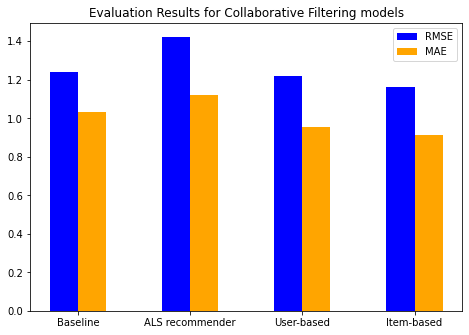

In [51]:
import numpy as np
import matplotlib.pyplot as plt
data = [[1.2415,1.4235,1.2169,1.1639],
[1.0313,1.1205,0.9537,0.9126]]
labels = ['Baseline', 'ALS recommender','User-based','Item-based']
X = np.arange(len(labels)) 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.25/2, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25/2, data[1], color = 'orange', width = 0.25)
ax.set_xticks(X)
ax.set_xticklabels(labels)
ax.legend(labels=['RMSE', 'MAE'])
plt.title('Evaluation Results for Collaborative Filtering models')